In [29]:
# default_exp correlation

# Correlation analysis of features selected

In [2b_median_mad_based_sample_and_feature_selection](2b_median_mad_based_sample_and_feature_selection) a number of samples and features were retained for further analysis. In this notebook we examine the correlation between these features.

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
# %load common.py
# export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from matplotlib import cm
from importlib import reload
from ehv import core
from joblib import load, dump
from pathlib import Path
import uuid
import re
import scipy

from ehv import load as e_load, core

plt.rcParams['figure.facecolor'] = 'white'

numpy.random.seed(42)

In [90]:
# export
import copy
from sklearn.base import clone, BaseEstimator, TransformerMixin

In [92]:
import umap
import dask.dataframe as dd
import statsmodels.api as sm
from tqdm.notebook import tqdm

In [33]:
# ONLY LOADING LOW

# samples = pandas.read_csv("data/selected_samples.csv")
samples = None
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    samples, "Low/*.cif")
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)
df = e_load.clean_column_names(df)

In [34]:
df = df[df["meta_label_coi"]]
df.shape

(339045, 113)

In [35]:
import re
reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

In [36]:
df.shape

(339045, 114)

In [37]:
df.filter(regex="meta").shape

(339045, 12)

# Iterative feature elimination

Correlation for all pairwise feature combinations is computed. For each pair, one feature is dropped if the correlation is above a threshold.

In [38]:
df.filter(regex="feat").corr().mean().mean()

0.12099645526497728

In [93]:
#export
class Correlation(BaseEstimator, TransformerMixin):
    
    def __init__(self, thresh):
        self.thresh = thresh
    
    def fit(self, df):
        correlation, var = df.corr(), df.var()
        drops, keeps = list(), list()

        # loop over all feature combinations
        for i in range(correlation.shape[0]):
            for j in range(i):

                # check absolute value of correlation against threshold
                if abs(correlation.iloc[i, j]) > self.thresh:

                    # keep feature with most variance
                    drop = i if var[correlation.columns[i]] >= var[correlation.columns[j]] else j
                    keep = j if drop == i else i
                    drops.append(correlation.columns[drop])
                    keeps.append(correlation.columns[keep])
                    
        self.correlated = set(drops)
        self.combinations = list(zip(drops, keeps))
        return self
        
    def transform(self, df):
        return df.drop(columns=self.correlated)

In [84]:
from joblib import Parallel, delayed

In [85]:
thresholds = numpy.linspace(0.5, 0.99, 30)
    
def get_mean_corr(t):
    model = Correlation(t)
    model.fit(df.filter(regex="feat"))
    correlated_features = model.correlated
    correlation = model.transform(df).corr()
    return correlation.mean().mean()/correlation.shape[0]

results = Parallel(n_jobs=20)(delayed(get_mean_corr)(t) for t in thresholds)

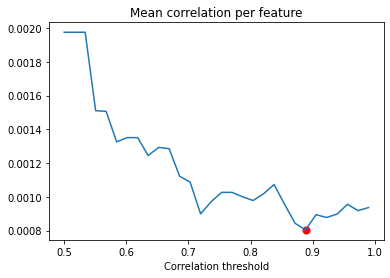

In [86]:
plt.plot(thresholds, results)
plt.xlabel("Correlation threshold")
plt.title("Mean correlation per feature")

idx = numpy.array(results).argmin()
plt.scatter(thresholds[idx], results[idx], s=50, color="red")
# plt.savefig("figs/mean_corr_per_feature.png", dpi=150)

In [49]:
thresholds[numpy.array(results).argmin()]

0.9224137931034482

In [24]:
correlated_features, other = get_correlated_features(df.filter(regex="feat"), thresh=thresholds[numpy.array(results).argmin()])
correlation = df.drop(columns=correlated_features).corr()
correlation.mean().mean()

0.08062259638103829

In [27]:
list(zip(correlated_features, other))

[('feat_area_m01', 'feat_area_m09'),
 ('feat_aspect_ratio_intensity_m03_ch03', 'feat_aspect_ratio_m03'),
 ('feat_aspect_ratio_intensity_m04_ch04', 'feat_aspect_ratio_m04'),
 ('feat_intensity_mc_ch03', 'feat_intensity_mc_ch7'),
 ('feat_median_pixel_m03_ch03', 'feat_mean_pixel_m03_ch03'),
 ('feat_median_pixel_m04_ch04', 'feat_mean_pixel_m04_ch04'),
 ('feat_median_pixel_m06_ssc', 'feat_mean_pixel_m06_ssc'),
 ('feat_median_pixel_m07_ch7', 'feat_mean_pixel_m07_ch7'),
 ('feat_median_pixel_m11_ch11', 'feat_mean_pixel_m11_ch11'),
 ('feat_mean_pixel_m04_ch04', 'feat_max_pixel_mc_ch04'),
 ('feat_median_pixel_m04_ch04', 'feat_max_pixel_mc_ch04'),
 ('feat_mean_pixel_m06_ssc', 'feat_max_pixel_mc_ssc'),
 ('feat_mean_pixel_m07_ch7', 'feat_max_pixel_mc_ch7'),
 ('feat_length_m04', 'feat_area_m04'),
 ('feat_width_m04', 'feat_area_m04'),
 ('feat_width_m04', 'feat_length_m04'),
 ('feat_height_m03', 'feat_length_m03'),
 ('feat_height_m04', 'feat_area_m04'),
 ('feat_height_m04', 'feat_length_m04'),
 ('feat_

In [18]:
df.filter(regex="feat").shape

(339045, 102)

In [28]:
df.drop(columns=set(correlated_features)).filter(regex="feat").head()

,feat_area_m03,feat_area_m04,feat_area_m06,feat_area_m07,feat_area_m09,feat_area_m11,feat_area_mc,feat_aspect_ratio_m01,feat_aspect_ratio_m03,feat_aspect_ratio_m04,...,feat_height_m09,feat_bright_detail_intensity_r3_mc_bf,feat_bright_detail_intensity_r3_mc_ch03,feat_bright_detail_intensity_r3_mc_ch04,feat_bright_detail_intensity_r3_mc_ch7,feat_bright_detail_intensity_r3_mc_bf2,feat_bright_detail_intensity_r3_mc_ch11,feat_max_pixel_m02_ch02,feat_intensity_m02_ch02,feat_similarity_m01_ch02_ch03
8,5.222222,0.0,14.444445,17.777779,23.000000,19.444445,25.555555,0.921710,0.819040,0.0,...,5.333333,3042.0,920.0,263.0,12002.999023,2217.0,10415.0,10.191176,283.602936,2.021338
9,8.333333,0.0,35.111111,18.666666,51.000000,25.111111,69.111115,0.357953,0.865995,0.0,...,13.333333,6231.0,2549.0,995.0,17221.000000,6672.0,10430.0,14.187500,469.000000,2.211377
12,0.000000,0.0,26.111111,26.444445,46.444443,50.888889,55.333332,0.750179,0.000000,0.0,...,8.000000,7623.0,1783.0,806.0,4874.000000,8029.0,3385.0,9.895833,291.416656,0.950580
14,9.555555,0.0,35.555557,37.777779,73.888885,50.888889,105.666664,0.603159,0.809759,0.0,...,13.666667,10389.0,2900.0,1345.0,8395.000000,11876.0,3053.0,9.750000,498.750000,1.147965
26,8.444445,0.0,14.111111,19.333334,17.555555,22.000000,27.888889,0.910296,0.812738,0.0,...,4.666667,3845.0,969.0,371.0,22586.001953,1842.0,22736.0,15.378049,559.731689,1.147697
